<a href="https://colab.research.google.com/github/BATiger/Classic/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from torch import optim
import matplotlib.pyplot as plt

import torch
import cv2
import os
import glob
from torch.utils.data import Dataset
import random

In [ ]:
#不改变大小
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.block(x)

# 降采样 + 双卷积
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2,stride=2),
            DoubleConv(in_channels, out_channels),
        )
    
    def forward(self, x):
        return self.block(x)



# up模块 1)扩大feature map大小 2)连接前面的feature map 3)左大右小
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        # 长宽放大两倍，channel数量减半
        if bilinear:
            self.up = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64,128)
        self.down2 = Down(128,256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,1024)

        self.up1 = Up(1024,512,bilinear)
        self.up2 = Up(512,256,bilinear)
        self.up3 = Up(256,128,bilinear)
        self.up4 = Up(128,64,bilinear)
        self.outc = OutConv(64,n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5,x4)
        x = self.up2(x,x3)
        x = self.up3(x,x2)
        x = self.up4(x,x1)
        x = self.outc(x)
        return x


In [ ]:
t = transforms.Compose([
      transforms.ToTensor()
])

device = torch.device('cuda')
batch = 2
lr = 0.0001
epochs = 40

In [ ]:
train_dir = 'drive/My Drive/ClassicCode/segmentation/train/'

In [ ]:
class ISBI_Loader(Dataset):
    def __init__(self, data_path):
        # 初始化函数，读取所有data_path下的图片
        self.data_path = data_path
        # imgs_path 包含所有满足正则的文件名
        self.imgs_path = glob.glob(os.path.join(data_path, 'image/*.png'))
 
    def augment(self, image, flipCode):
        # 使用cv2.flip进行数据增强，filpCode为1水平翻转，0垂直翻转，-1水平+垂直翻转
        flip = cv2.flip(image, flipCode)
        return flip
        
    def __getitem__(self, index):
        # 根据index读取图片
        image_path = self.imgs_path[index]
        # 根据image_path生成label_path
        label_path = image_path.replace('image', 'label')
        # 读取训练图片和标签图片
        image = cv2.imread(image_path)
        label = cv2.imread(label_path)
        # 将数据转为单通道的图片
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        image = image.reshape(1, image.shape[0], image.shape[1])
        label = label.reshape(1, label.shape[0], label.shape[1])
        # 处理标签，将像素值为255的改为1
        if label.max() > 1:
            label = label / 255
        # 随机进行数据增强，为2时不做处理
        flipCode = random.choice([-1, 0, 1, 2])
        if flipCode != 2:
            image = self.augment(image, flipCode)
            label = self.augment(label, flipCode)
        return image, label
 
    def __len__(self):
        # 返回训练集大小
        return len(self.imgs_path)

torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])


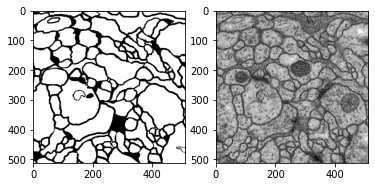

In [ ]:
dataset = ISBI_Loader(train_dir)

train_loader = DataLoader(dataset,batch_size=batch,shuffle=True)

image,label = next(iter(train_loader))
print(image.shape)
print(label.shape)

figure = plt.figure()
figure.add_subplot(1,2,1)
plt.imshow(label[0][0],cmap='gray')
figure.add_subplot(1,2,2)
plt.imshow(image[0][0],cmap='gray')
plt.show()

In [ ]:
model = UNet(1, 1).to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
criterion = nn.BCEWithLogitsLoss()

model.train()
for epoch in range(epochs):
    for image, label in train_loader:
        image = image.to(device,dtype=torch.float32)
        label = label.to(device,dtype=torch.float32)

        pred = model(image)

        loss = criterion(pred, label)
        print('loss/train',loss.item())

        loss.backward()
        optimizer.step()

loss/train 0.7488973140716553
loss/train 0.7206403613090515
loss/train 0.6668651103973389
loss/train 0.6672461032867432
loss/train 0.6291750073432922
loss/train 0.6136903762817383
loss/train 0.6214784383773804
loss/train 0.6174724102020264
loss/train 0.6440832018852234
loss/train 0.6205126047134399
loss/train 0.585200846195221
loss/train 0.5621337294578552
loss/train 0.5687859654426575
loss/train 0.5354567766189575
loss/train 0.544753909111023
loss/train 0.556094765663147
loss/train 0.5772563219070435
loss/train 0.5381417274475098
loss/train 0.5138888955116272
loss/train 0.5482158064842224
loss/train 0.5144835114479065
loss/train 0.5143024921417236
loss/train 0.48110681772232056
loss/train 0.469881534576416
loss/train 0.503553032875061
loss/train 0.4809189736843109
loss/train 0.4823382496833801
loss/train 0.4940376281738281
loss/train 0.49067553877830505
loss/train 0.4697313904762268
loss/train 0.5002138018608093
loss/train 0.4766766428947449
loss/train 0.49778181314468384
loss/train 0

In [ ]:
import numpy as np

model.eval()
test_paths = glob.glob('drive/My Drive/ClassicCode/segmentation/test/image/*.png')

for test_path in test_paths:
        save_res_path = test_path.split('.')[0] + '_res.png'
        # 读取图片
        img = cv2.imread(test_path)
        # 转为灰度图
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 转为batch为1，通道为1，大小为512*512的数组
        img = img.reshape(1, 1, img.shape[0], img.shape[1])
        # 转为tensor
        img_tensor = torch.from_numpy(img)
        # 将tensor拷贝到device中，只用cpu就是拷贝到cpu中，用cuda就是拷贝到cuda中。
        img_tensor = img_tensor.to(device=device, dtype=torch.float32)
        # 预测
        pred = model(img_tensor)
        # 提取结果
        pred = np.array(pred.data.cpu()[0])[0]
        # 处理结果
        pred[pred >= 0.5] = 255
        pred[pred < 0.5] = 0
        # 保存图片
        cv2.imwrite(save_res_path, pred)